In [1]:
# Include so results on different machines are (should be) the same.
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
!jupyter nbconvert --to script Keras_BagnallCharacter_MultiHeadRNN.ipynb

[NbConvertApp] Converting notebook Keras_BagnallCharacter_MultiHeadRNN.ipynb to script
[NbConvertApp] Writing 14480 bytes to Keras_BagnallCharacter_MultiHeadRNN.py


In [3]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
presidents = [
    "Barack Obama",
    "Donald J. Trump",
#     "Dwight D. Eisenhower",
#     "Franklin D. Roosevelt",
#     "George Bush",
    "George W. Bush",
#     "Gerald R. Ford",
#     "Harry S. Truman",
#     "Herbert Hoover",
#     "Jimmy Carter",
#     "John F. Kennedy",
#     "Lyndon B. Johnson",
#     "Richard Nixon",
#     "Ronald Reagan",
    "William J. Clinton"
]

labels = {}
for idx, name in enumerate(presidents):
    labels[name] = idx

# load raw text files straight in, no parsing
file_to_label = {
    "Obama": "Barack Obama",
    "Trump": "Donald J. Trump",
#     "Eisenhower": "Dwight D. Eisenhower",
#     "Roosevelt": "Franklin D. Roosevelt",
#     "Bush": "George Bush",
    "WBush": "George W. Bush",
#     "Ford": "Gerald R. Ford",
#     "Truman": "Harry S. Truman",
#     "Hoover": "Herbert Hoover",
#     "Carter": "Jimmy Carter",
#     "Kennedy": "John F. Kennedy",
#     "Johnson": "Lyndon B. Johnson",
#     "Nixon": "Richard Nixon",
#     "Reagan": "Ronald Reagan",
    "Clinton": "William J. Clinton"
}

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 34 speeches for 4 presidents.
Loaded 290 speeches for 4 presidents.


In [4]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_}+"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    # "Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '\'', loaded_text[x])
    loaded_text[x] = re.sub('--', '-', loaded_text[x])
    loaded_text[x] = re.sub('\n\n', '\n', loaded_text[x])
    # "...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]+', '7', loaded_text[x])
    # "...any character with a frequency lower than 1 in 10,000 is discarded."
    loaded_text[x] = loaded_text[x].translate(trantab)
    # "Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])

print "Replacements complete."

Replacements complete.


In [5]:
#
# Join all speeches into one massive per president
#  for later processing
#
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Barack Obama         	4869126
1  : Donald J. Trump      	555750
2  : George W. Bush       	1792991
3  : William J. Clinton   	1786719

Minimum number of characters per president?
555750


In [6]:
#
# Tokenize words into chars
#
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

# there's an oddity in the encoding for some reason where a len+1 character occurs
unique_chars = len(tokenizer.word_counts)+1

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


Unique char count: 68

Chars w/ counts:
[(1611159, ' '), (879201, 'e'), (725072, 't'), (568823, 'o'), (551892, 'a'), (504754, 'n'), (482361, 'i'), (423814, 's'), (408565, 'r'), (357681, 'h'), (261863, 'l'), (244476, 'd'), (192987, 'u'), (187789, 'c'), (160541, 'm'), (151341, 'g'), (151110, 'w'), (136137, 'p'), (128341, 'y'), (126745, 'f'), (97526, 'b'), (88613, ','), (86646, '.'), (80552, 'v'), (60491, 'k'), (51483, 'I'), (49550, "'"), (31955, 'A'), (16842, '-'), (16652, 'T'), (16621, 'S'), (12156, 'W'), (10475, 'x'), (10326, 'j'), (9142, 'C'), (8911, '7'), (8377, 'B'), (7686, 'P'), (7596, 'q'), (6171, 'N'), (6156, 'M'), (5368, 'R'), (4970, 'G'), (4545, 'U'), (4396, 'z'), (4292, 'H'), (4174, 'O'), (3789, 'E'), (3644, 'D'), (3485, '?'), (3353, 'F'), (3350, 'L'), (3056, ';'), (2897, 'Y'), (2752, '\n'), (2549, '"'), (2388, 'J'), (1697, 'K'), (1581, '/'), (1447, ':'), (722, '$'), (712, 'V'), (598, 'Q'), (162, 'Z'), (70, 'X'), (6, '#'), (4, '\\')]


In [7]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size):
    output_list = []
    for idx in range(0, len(_list), _split_size):
        if (idx + _split_size) <= len(_list):
            output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 50

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx]#[:label_min_chars]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print "Subsequence total count; subsequence label total count:", len( split_text ), len( split_labels )
print "\nTotal characters:", len( split_text ) * max_seq_len

Subsequence total count; subsequence label total count: 180090 180090

Total characters: 9004500


In [8]:
#
# split amongst speaker samples, not the whole population of samples
#
def split_test_train(input_text, input_labels, labels, train_pct=0.8):
    train_text = []
    train_labels = []
    test_text = []
    test_labels = []

    for key, value in sorted(labels.iteritems()):
        # grab all values of a specific label
        subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
        subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))
        
        cut_pos = int(train_pct * len(subset_text))
        train_text = train_text + subset_text[:cut_pos]
        train_labels = train_labels + subset_labels[:cut_pos]
        test_text = test_text + subset_text[cut_pos:]
        test_labels = test_labels + subset_labels[cut_pos:]
        
    return train_text,train_labels,test_text,test_labels

In [9]:
#
# Prep test/train
#
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

# split data smartly
train_X, train_y, test_X, test_y = split_test_train(split_text, split_labels, 
                                                    labels, train_pct=0.8)
print "Splits:\n Test = ", len(train_X), "\n Train = ", len(test_X)##

# compute class weights to account for imbalanced classes
y_weights = (class_weight.compute_class_weight('balanced', np.unique(train_y), train_y)).tolist()
y_weights = dict(zip(sorted(labels.values()), y_weights))
print "Class weights:\n", y_weights

Splits:
 Test =  144071 
 Train =  36019
Class weights:
{0: 0.46232911879853666, 1: 4.050579172289699, 2: 1.2555425802628368, 3: 1.2599345856508204}


In [10]:
#
# One-hot encoding classes & samples
#
from keras.utils import to_categorical

# one-hot encode classes
train_y = np.array(to_categorical(train_y))
test_y = np.array(to_categorical(test_y))

# one-hot encode samples
train_X = np.array(train_X)
orig_train_X_size=train_X.shape[0]
print "Encoding train_X with dimensions ", train_X.shape
train_X = to_categorical(train_X, num_classes=unique_chars)
print "...to ", train_X.shape
train_X = np.reshape(train_X,(orig_train_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", train_X.shape

test_X = np.array(test_X)
orig_test_X_size=test_X.shape[0]
print "\nEncoding test_X with dimensions ", test_X.shape
test_X = to_categorical(test_X, num_classes=unique_chars)
print "...to ", test_X.shape
test_X = np.reshape(test_X,(orig_test_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", test_X.shape

Encoding train_X with dimensions  (144071, 50)
...to  (7203550, 68)
...and reshaping to  (144071, 50, 68)

Encoding test_X with dimensions  (36019, 50)
...to  (1800950, 68)
...and reshaping to  (36019, 50, 68)


In [11]:
# custom activation from Bagnall 2015
#  we were never able to get this to work; either nan'ed or never converged
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects

def ReSQRT(x):
    cond = tf.less_equal(x, 0.0)
    result = tf.where(cond, x * 0.0, tf.sqrt(x+1)-1)
    return result

get_custom_objects().update({'ReSQRT': ReSQRT})

Bagnall proposes that the following possible values contribute to the success of the model:

| meta-parameter                  	| typical value                      	|
|---------------------------------	|------------------------------------	|
| initial adagrad learning scale  	| 0.1, 0.14, 0.2, 0.3                	|
| initial leakage between classes 	| 1/4N to 5/N                        	|
| leakage decay (per sub-epoch)   	| 0.67 to 0.9                        	|
| hidden neurons                  	| 79, 99, 119, 139                   	|
| presynaptic noise σ             	| 0, 0.1, 0.2, 0.3, 0.5              	|
| sub-epochs                      	| 6 to 36                            	|
| text direction                  	| forward or backward                	|
| text handling                   	| sequential, concatenated, balanced 	|
| initialisation                  	| gaussian, zero                     	|

In [23]:
##
## BASELINE
##
from keras.layers import Input, Dense, SimpleRNN, Bidirectional, Dropout
from keras.layers.merge import Maximum, Add
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.layers.merge import Average, Maximum
from keras.optimizers import Adagrad, adam
from keras.models import Model
from keras.utils import plot_model

# define operating vars
activation = "relu"
units = 150# 50
dropout = 0.7646166765488501
batch_size = 50# 100
epochs = 50
optimizer='adamax'#'rmsprop'
shuffle=True #False -- false not good

# define any callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
              patience=1, verbose=1)
csv_logger = CSVLogger('Keras_BagnallCharacter_MultiHeadRNN.log')

# assemble & compile model
input = Input(shape=(max_seq_len,unique_chars,))
rnn = Bidirectional(SimpleRNN(units=units,activation=activation))(input)

soft1_out =  Dense(4,activation='softmax',kernel_initializer='random_uniform')(rnn)
soft2_out =  Dense(4,activation='softmax',kernel_initializer='random_uniform')(rnn)
soft3_out =  Dense(4,activation='softmax',kernel_initializer='random_uniform')(rnn)
soft4_out =  Dense(4,activation='softmax',kernel_initializer='random_uniform')(rnn)

## PRETTY SURE THIS DOESN"T MAKE COMPLETE SENSE...
## BUT IF IT DOES, ADD MIGHT WORK BETTER??
## BUT DEFINITELY TRY A BUNCH OF BINARIES AND OUTPUT THEM ALL 
#    THEN USE THE APPROACH IN THE LINK TO COMPUTE ONE SET OF PREDS FOR ACCURACY
final_out = Add()([soft1_out,soft2_out,soft3_out,soft4_out])

model = Model(inputs=[input], outputs=[final_out])

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['categorical_accuracy'])
plot_model(model, to_file='Keras_BagnallCharacter_MultiHeadRNN.png', show_shapes=True, show_layer_names=True)
print(model.summary())


## OK SO:
##  ( ): SAME INPUT; MULTI SOFTMAX, NO MERGE
##  ( 41.3 @ 5; 45.7 @ 10 ): SAME INPUT; MULTI SOFTMAX, WITH MERGE(MAX)
##  ( 41.7 @ 5; 48.1 @ 10 ): SAME INPUT; MULTI SOFTMAX, WITH MERGE(ADD)
##  ( ): SPLIT INPUT; MULTI SOFTMAX, NO MERGE
##  ( ): SPLIT INPUT; MULTI SOFTMAX, MERGE

##  ( ): SAME INPUT; BINARY-CROSS ENTROPY W/ SIGMOIDS, NO MERGE
##  ( ): SAME INPUT; BINARY-CROSS ENTROPY W/ SIGMOIDS, WITH MERGE(?)
##  ( ): SPLIT INPUT; BINARY-CROSS ENTROPY, NO MERGE
##  ( ): SPLIT INPUT; BINARY-CROSS ENTROPY W/ SIGMOIDS, WITH MERGE(?)

#https://groups.google.com/forum/#!topic/keras-users/cpXXz_qsCvA
out_data1 = np.copy(train_y)
# out_data1[:,1] = 0
# out_data1[:,2] = 0
# out_data1[:,3] = 0

out_data2 = np.copy(train_y)
# out_data2[:,0] = 0
# out_data2[:,1] = 0
# out_data2[:,2] = 0

out_data3 = np.copy(train_y)
# out_data3[:,0] = 0
# out_data3[:,1] = 0
# out_data3[:,3] = 0

out_data4 = np.copy(train_y)
# out_data4[:,0] = 0
# out_data4[:,1] = 0
# out_data4[:,2] = 0

# train
model.fit([np.array(train_X)],
          [np.array(train_y)],#[out_data1, out_data2, out_data3, out_data4],
          batch_size=batch_size,
          epochs=epochs,
          shuffle=shuffle,
          class_weight = y_weights,
          callbacks=[reduce_lr, csv_logger],
          verbose=1)

model.save('Keras_BagnallCharacter_MultiHeadRNN.h5')
print ("Model saved.")
del model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 50, 68)        0                                            
____________________________________________________________________________________________________
bidirectional_8 (Bidirectional)  (None, 300)           65700       input_8[0][0]                    
____________________________________________________________________________________________________
dense_29 (Dense)                 (None, 4)             1204        bidirectional_8[0][0]            
____________________________________________________________________________________________________
dense_30 (Dense)                 (None, 4)             1204        bidirectional_8[0][0]            
___________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
# Load computed model
from keras.models import load_model
# returns a compiled model identical to the one trained
model = load_model('Keras_BagnallCharacter_MultiHeadRNN.h5')

In [21]:
from sklearn import metrics

# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y) #[test_y,test_y,test_y,test_y])
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)
print "\n\nDone prediction."

print "\nAUC = ", metrics.roc_auc_score(test_y, pred_y)

Evaluating test data...
36019/36019 [==============================] - 12s    
['loss', 'categorical_accuracy']
[1.2953604603598763, 0.38157639024014006]

Predicting using test data...
35950/36019 [============================>.] - ETA: 0s

Done prediction.

AUC =  0.655562056745


Confusion matrix, without normalization
[ 8047  3851 11916 12205]
[[5738 1845 5129 6765]
 [ 201  765  713  544]
 [ 963  516 4019 1674]
 [1145  725 2055 3222]]
Normalized confusion matrix
[[ 0.29  0.09  0.26  0.35]
 [ 0.09  0.34  0.32  0.24]
 [ 0.13  0.07  0.56  0.23]
 [ 0.16  0.1   0.29  0.45]]


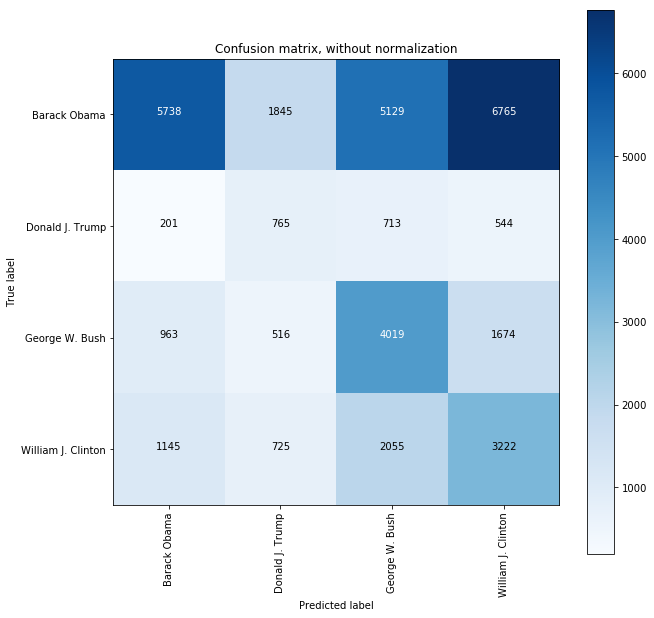

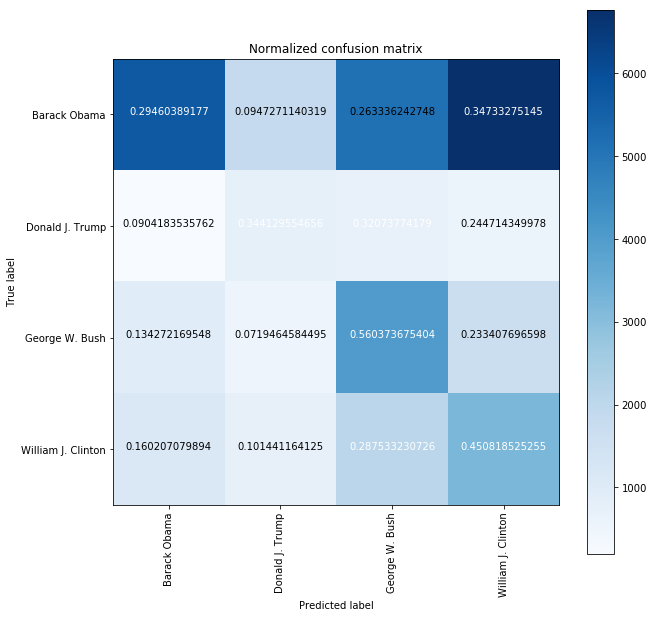

In [22]:
# Plot confusion matrix
#   from scikit-learn examples @
#   http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(np.sum(cm,axis=0))

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(np.round(cnf_matrix,2), classes=(sorted(labels, key=labels.get)), normalize=True,
                      title='Normalized confusion matrix')

plt.show()